## Importing the libraries

In [32]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Fetching the dataset

In [33]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

## Loading the dataset

In [34]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


## Exploartory Data Analysis

In [35]:
citations.sample(frac=1).head()

,target,source
2025,15429,217115
2832,34257,34266
2321,20924,289885
58,35,15670
2052,15987,523394


In [36]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [37]:
print(papers.sample(5).T)

                      143     2694                1831             330   \
paper_id            219446  767763              592973          1132968   
term_0                   0       0                   0                0   
term_1                   0       0                   0                0   
term_2                   0       0                   1                0   
term_3                   0       0                   0                0   
...                    ...     ...                 ...              ...   
term_1429                0       0                   0                0   
term_1430                0       0                   0                0   
term_1431                0       0                   0                0   
term_1432                0       0                   0                0   
subject    Neural_Networks  Theory  Genetic_Algorithms  Neural_Networks   

             2618  
paper_id   429781  
term_0          0  
term_1          0  
term_2          0  

In [38]:
print(papers.subject.value_counts())

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


In [39]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

## Constucting the graphs

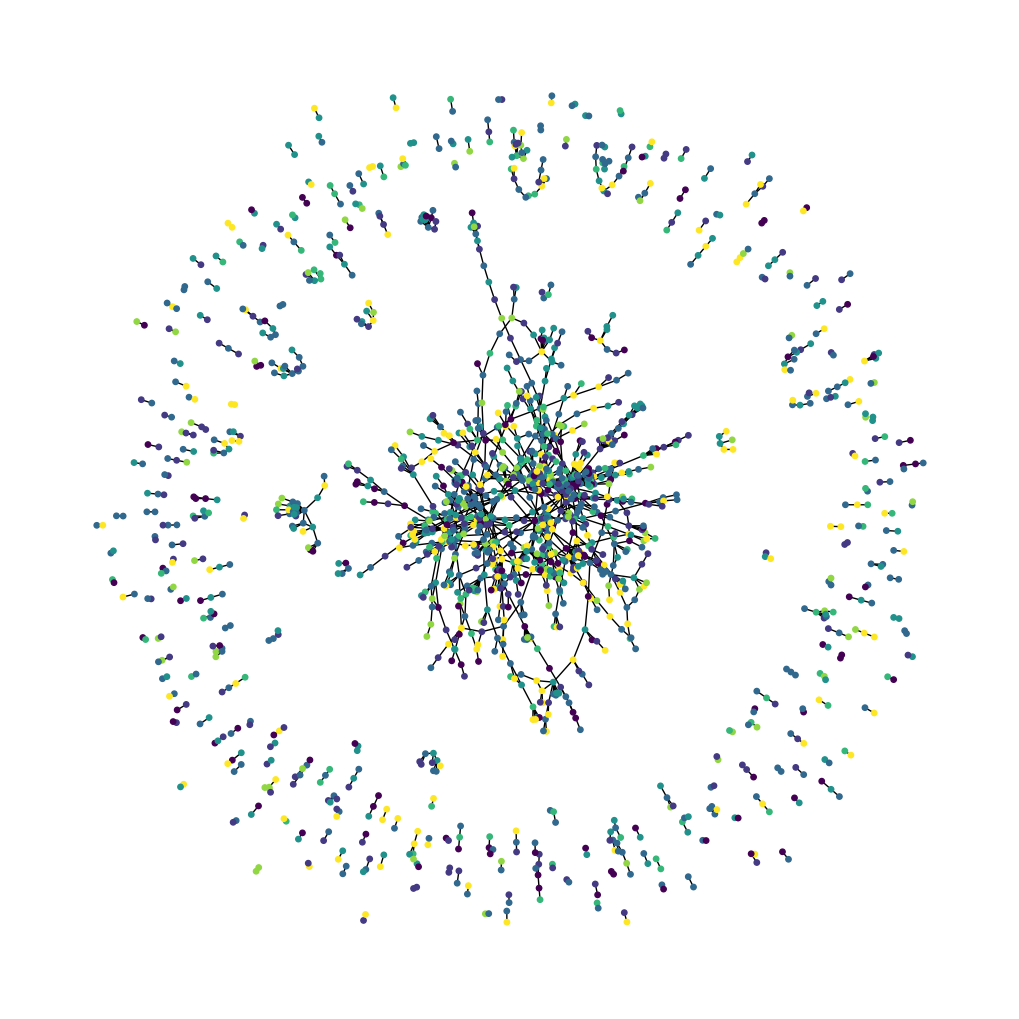

In [40]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

## Splitting the train-test split

In [41]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1363, 1435)
Test data shape: (1345, 1435)


## Defined hyperparameters for the baseline GNN Architecture

In [42]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

## Functions to train the model and plot the curves

In [43]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


"""
This function displays the loss and accuracy curves of the model during training.
"""


def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


### Function for creating the feed forward network for preprocessing and postprocessing the inputs in the GNN models

In [44]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [45]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]


In [46]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 1433)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block1          │ (None, 32)        │     52,804 │ input_features[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block2          │ (None, 32)        │      2,368 │ ffn_block1[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection2    │ (None, 32)        │          0 │ ffn_block1[0][0], │
│ (Add)               │                   │            │ ffn_block2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block3          │ (None, 32)        │      2,368 │ skip_connection2… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection3    │ (None, 32)        │          0 │ skip_connection2… │
│ (Add)               │                   │            │ ffn_block3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block4          │ (None, 32)        │      2,368 │ skip_connection3… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection4    │ (None, 32)        │          0 │ skip_connection3… │
│ (Add)               │                   │            │ ffn_block4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block5          │ (None, 32)        │      2,368 │ skip_connection4… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection5    │ (None, 32)        │          0 │ skip_connection4… │
│ (Add)               │                   │            │ ffn_block5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 7)         │        231 │ skip_connection5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,507 (244.17 KB)

 Trainable params: 59,065 (230.72 KB)

 Non-trainable params: 3,442 (13.45 KB)

In [50]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [51]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Instance 1:
- Case_Based: 3.66%
- Genetic_Algorithms: 8.76%
- Neural_Networks: 10.34%
- Probabilistic_Methods: 9.75%
- Reinforcement_Learning: 6.71%
- Rule_Learning: 12.95%
- Theory: 47.84%
Instance 2:
- Case_Based: 0.94%
- Genetic_Algorithms: 12.39%
- Neural_Networks: 44.46%
- Probabilistic_Methods: 10.74%
- Reinforcement_Learning: 19.05%
- Rule_Learning: 0.19%
- Theory: 12.23%
Instance 3:
- Case_Based: 11.81%
- Genetic_Algorithms: 21.54%
- Neural_Networks: 55.22%
- Probabilistic_Methods: 9.42%
- Reinforcement_Learning: 1.26%
- Rule_Learning: 0.26%
- Theory: 0.49%
Instance 4:
- Case_Based: 2.79%
- Genetic_Algorithms: 24.72%
- Neural_Networks: 69.58%
- Probabilistic_Methods: 1.22%
- Reinforcement_Learning: 0.89%
- Rule_Learning: 0.41%
- Theory: 0.4%
Instance 5:
- Case_Based: 1.44%
- Genetic_Algorithms: 5.21%
- Neural_Networks: 82.29%
- Probabilistic_Methods: 1.7%
- Reinforcement_Learning: 7.88%
- Rule_Learning: 0.39%
- Theory: 1.08%
Instance 6:
- 

##### Reference to https://keras.io/examples/graph/gnn_citations/

## Data Preparation for implemention GNNs

In [52]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)


Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


### Defining the GRU and Graph Convolutional layer

In [53]:
def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
        x = layers.GRU(
            units=units,
            activation="tanh",
            recurrent_activation="sigmoid",
            return_sequences=True,
            dropout=dropout_rate,
            return_state=False,
            recurrent_dropout=dropout_rate,
        )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

### Baseline GNN Architecture

In [54]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

Reference to https://keras.io/examples/graph/gnn_citations/

In [55]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

node_indices = tf.constant([1, 10, 100], dtype=tf.int32)
output = gnn_model(node_indices)

print("GNN output shape:", output.shape)

gnn_model.summary()


GNN output shape: (3, 7)


Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ (2708, 32)             │        52,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ (2708, 32)             │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (3, 7)                 │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,179 (262.42 KB)

 Trainable params: 63,481 (247.97 KB)

 Non-trainable params: 3,698 (14.45 KB)

## Training the baseline GNN model

In [56]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - acc: 0.2066 - loss: 1.9010 - val_acc: 0.2829 - val_loss: 1.7894
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - acc: 0.4527 - loss: 1.5482 - val_acc: 0.4049 - val_loss: 1.7427
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - acc: 0.5291 - loss: 1.3016 - val_acc: 0.4976 - val_loss: 1.3599
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - acc: 0.6416 - loss: 0.9080 - val_acc: 0.5902 - val_loss: 1.2684
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc: 0.8180 - loss: 0.5783 - val_acc: 0.6634 - val_loss: 1.3397
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - acc: 0.9066 - loss: 0.3191 - val_acc: 0.7317 - val_loss: 1.4310
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - acc: 0.9522 - loss: 0.1569 - val_acc: 0.6878 - val_loss: 1.5597
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.9757 - loss: 0.0723 - val_acc: 0.7268 - val_loss: 1.8665
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.9827 - loss

### Plotting the baseline GNN curves

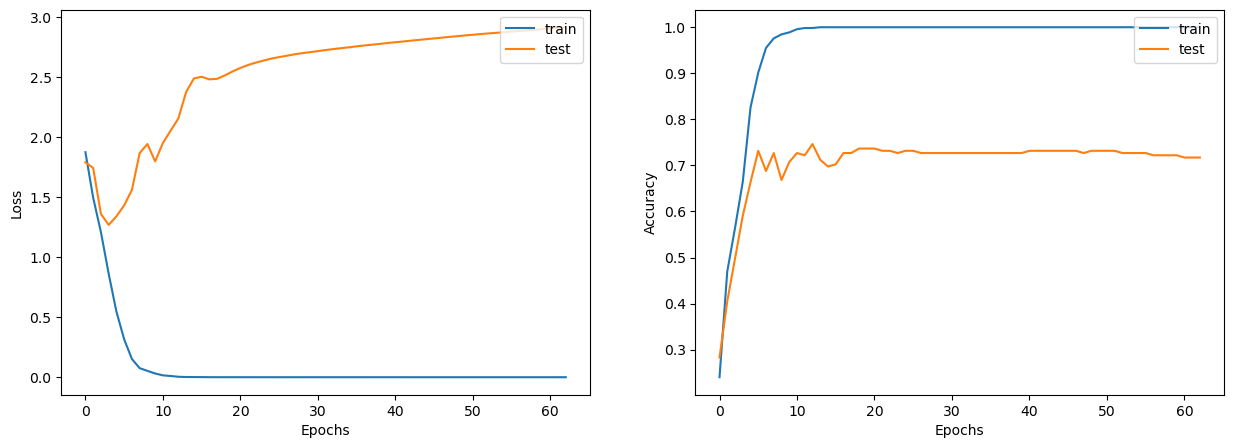

'\nNow we evaluate the GNN model on the test data split.\nThe results may vary depending on the training sample, however the GNN model always outperforms\nthe baseline model in terms of the test accuracy.\n'

In [57]:
display_learning_curves(history)

In [58]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 70.71%


### Prediction using baseline GNN Architecture

In [59]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [60]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)



Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Instance 1:
- Case_Based: 0.12%
- Genetic_Algorithms: 0.39%
- Neural_Networks: 0.03%
- Probabilistic_Methods: 69.37%
- Reinforcement_Learning: 3.43%
- Rule_Learning: 21.65%
- Theory: 5.01%
Instance 2:
- Case_Based: 0.34%
- Genetic_Algorithms: 11.36%
- Neural_Networks: 16.06%
- Probabilistic_Methods: 47.13%
- Reinforcement_Learning: 21.85%
- Rule_Learning: 1.71%
- Theory: 1.55%
Instance 3:
- Case_Based: 0.17%
- Genetic_Algorithms: 8.07%
- Neural_Networks: 84.57%
- Probabilistic_Methods: 7.11%
- Reinforcement_Learning: 0.05%
- Rule_Learning: 0.03%
- Theory: 0.01%
Instance 4:
- Case_Based: 0.01%
- Genetic_Algorithms: 1.97%
- Neural_Networks: 95.71%
- Probabilistic_Methods: 1.94%
- Reinforcement_Learning: 0.3%
- Rule_Learning: 0.06%
- Theory: 0.01%
Instance 5:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.01%
- Neural_N

'\nNotice that the probabilities of the expected subjects\n(to which several citations are added) are higher compared to the baseline model.\n'

## Proposed GNN Architectures

#### Experiment 1: GNN Node Classifier 1

In [61]:
hidden_units = [64, 64]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 150
batch_size = 256

In [62]:
class ProposedGNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create the third GraphConv layer.
        self.conv3 = GraphConvLayer(
             hidden_units,
             dropout_rate,
             aggregation_type,
             combination_type,
             normalize,
             name="graph_conv3",
        )
        # Create the fourth GraphConv layer.
        self.conv4 = GraphConvLayer(
             hidden_units,
             dropout_rate,
             aggregation_type,
            combination_type,
             normalize,
             name="graph_conv4",
        )
        # Create the fifth GraphConv layer.
        self.conv5 = GraphConvLayer(
             hidden_units,
             dropout_rate,
             aggregation_type,
             combination_type,
             normalize,
             name="graph_conv5",
        )
        # Create the sixth GraphConv layer.
        self.conv6 = GraphConvLayer(
             hidden_units,
             dropout_rate,
             aggregation_type,
             combination_type,
             normalize,
             name="graph_conv6",
        )
        # Create the sixth GraphConv layer.
        self.conv7 = GraphConvLayer(
             hidden_units,
             dropout_rate,
             aggregation_type,
             combination_type,
             normalize,
             name="graph_conv7",
        )
        # Create the sixth GraphConv layer.
        self.conv8 = GraphConvLayer(
             hidden_units,
             dropout_rate,
             aggregation_type,
             combination_type,
             normalize,
             name="graph_conv8",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Apply the third graph conv layer.
        x3 = self.conv3((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x3 + x
        # Apply the fourth graph conv layer.
        x4 = self.conv4((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x4 + x
        # Apply the fifth graph conv layer.
        x5 = self.conv5((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x5 + x
        # Apply the sixth graph conv layer.
        x6 = self.conv6((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x6 + x
        # Apply the sixth graph conv layer.
        x7 = self.conv7((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x7 + x
        # Apply the sixth graph conv layer.
        x8 = self.conv8((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x8 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


#### Training the model

In [63]:
proposed_gnn_model = ProposedGNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[100,100],
    dropout_rate=0.5,
    name="proposed_gnn_model",
)

node_indices = tf.constant([1, 10, 100], dtype=tf.int32)
output = proposed_gnn_model(node_indices)

print("GNN output shape:", output.shape)

proposed_gnn_model.summary()

GNN output shape: (3, 7)


Model: "proposed_gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ (2708, 100)            │       159,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv3 (GraphConvLayer)    │ ?                      │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv4 (GraphConvLayer)    │ ?                      │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv5 (GraphConvLayer)    │ ?                      │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv6 (GraphConvLayer)    │ ?                      │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv7 (GraphConvLayer)    │ ?                      │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv8 (GraphConvLayer)    │ ?                      │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ (2708, 100)            │        21,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (3, 7)                 │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 600,539 (2.29 MB)

 Trainable params: 589,073 (2.25 MB)

 Non-trainable params: 11,466 (44.79 KB)

In [64]:
proposed_history = run_experiment(proposed_gnn_model, x_train, y_train)

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 871ms/step - acc: 0.1911 - loss: 2.0611 - val_acc: 0.3220 - val_loss: 1.8550
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - acc: 0.3779 - loss: 1.7310 - val_acc: 0.3659 - val_loss: 1.6592
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - acc: 0.5276 - loss: 1.3612 - val_acc: 0.5512 - val_loss: 1.2707
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step - acc: 0.7383 - loss: 0.8115 - val_acc: 0.6293 - val_loss: 1.2670
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - acc: 0.8608 - loss: 0.4285 - val_acc: 0.6341 - val_loss: 1.5954
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - acc: 0.9240 - loss: 0.2362 - val_acc: 0.6537 - val_loss: 1.4300
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 366ms/step - acc: 0.9589 - loss: 0.1482 - val_acc: 0.7122 - val_loss: 1.5388
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - acc: 0.9678 - loss: 0.0888 - val_acc: 0.6732 - val_loss: 1.7898
Epoch 9/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - acc: 0.979

#### Plotting the curves for the experiment 1

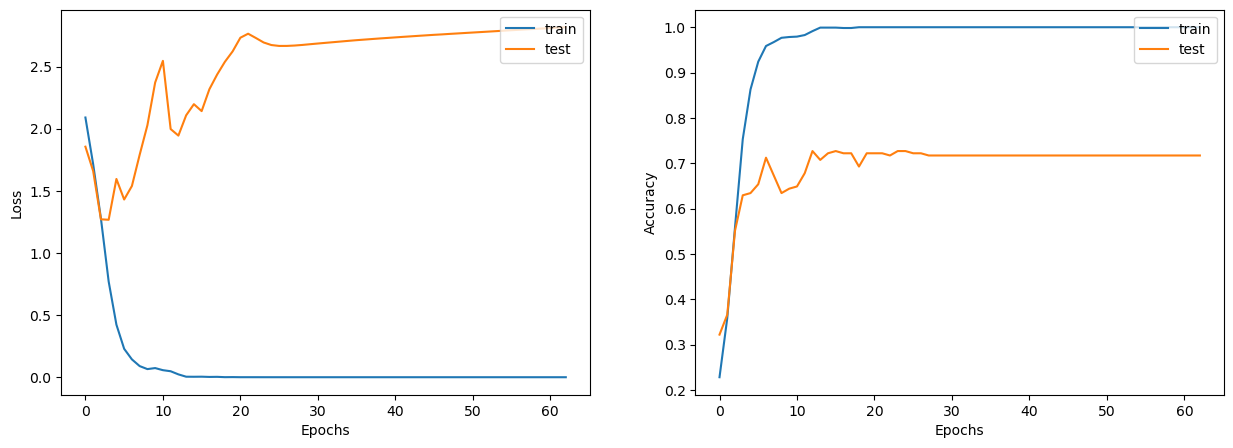

In [65]:
display_learning_curves(proposed_history)

In [66]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = proposed_gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 69.96%


#### Prediction using proposed GNN Node Classifier 1

In [67]:
print("Original node_features shape:", proposed_gnn_model.node_features.shape)
print("Original edges shape:", proposed_gnn_model.edges.shape)
proposed_gnn_model.node_features = new_node_features
proposed_gnn_model.edges = new_edges
proposed_gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", proposed_gnn_model.node_features.shape)
print("New edges shape:", proposed_gnn_model.edges.shape)

logits = proposed_gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Instance 1:
- Case_Based: 0.32%
- Genetic_Algorithms: 19.73%
- Neural_Networks: 1.39%
- Probabilistic_Methods: 20.49%
- Reinforcement_Learning: 0.84%
- Rule_Learning: 8.22%
- Theory: 49.01%
Instance 2:
- Case_Based: 0.0%
- Genetic_Algorithms: 1.81%
- Neural_Networks: 0.01%
- Probabilistic_Methods: 98.17%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.0%
- Theory: 0.01%
Instance 3:
- Case_Based: 3.7%
- Genetic_Algorithms: 21.48%
- Neural_Networks: 54.32%
- Probabilistic_Methods: 20.39%
- Reinforcement_Learning: 0.02%
- Rule_Learning: 0.05%
- Theory: 0.04%
Instance 4:
- Case_Based: 0.0%
- Genetic_Algorithms: 99.96%
- Neural_Networks: 0.02%
- Probabilistic_Methods: 0.01%
- Reinforcement_Learning: 0.0%
- Rule_Learning: 0.02%
- Theory: 0.0%
Instance 5:
- Case_Based: 1.55%
- Genetic_Algorithms: 5.81%
- Neural_Networ

In [68]:
logits = proposed_gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


#### Experiment 2: GNN Node Classifier 2

Hyperparameter Tuning

In [69]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers

def build_gnn_model(hp, graph_info, num_classes):
    # Define the hyperparameters to tune
    hidden_units = [hp.Int(f'hidden_units_{i}', min_value=8, max_value=128, step=8) for i in range(2)]
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    aggregation_type = hp.Choice('aggregation_type', values=['sum', 'mean', 'max'])
    combination_type = hp.Choice('combination_type', values=['concat', 'add'])
    normalize = hp.Boolean('normalize')
    
    model = ProposedGNNNodeClassifier(
        graph_info=graph_info,
        num_classes=num_classes,
        hidden_units=hidden_units,
        aggregation_type=aggregation_type,
        combination_type=combination_type,
        dropout_rate=dropout_rate,
        normalize=normalize,
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    return model



In [70]:
graph_info = graph_info
num_classes = num_classes
tuner = kt.RandomSearch(
    lambda hp: build_gnn_model(hp, graph_info, num_classes),
    objective='val_accuracy',
    max_trials=15, 
    executions_per_trial=1,
    directory='tuning_para',
    project_name='gnn_tuning'
)


Reloading Tuner from tuning_para\gnn_tuning\tuner0.json


In [71]:
tuner.search(
    x=x_train,
    y=y_train,
    epochs=100,  # You can adjust the number of epochs
    validation_data=(x_test, y_test)
)


In [72]:
tuner.get_best_hyperparameters

<bound method BaseTuner.get_best_hyperparameters of <keras_tuner.src.tuners.randomsearch.RandomSearch object at 0x0000012A51934A40>>

##### Training the model with best hyperparameters

In [73]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=50, restore_best_weights=True
    )
print(f"""
The hyperparameter search is complete. 
The optimal number of hidden units is {[best_hps.get(f'hidden_units_{i}') for i in range(2)]}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal aggregation type is {best_hps.get('aggregation_type')}.
The optimal combination type is {best_hps.get('combination_type')}.
The optimal normalization setting is {best_hps.get('normalize')}.
""")

# Build the best model and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=300,
    validation_split = 0.2,
    validation_data=(x_test, y_test),
    callbacks = [early_stopping]
)



The hyperparameter search is complete. 
The optimal number of hidden units is [88, 96].
The optimal dropout rate is 0.4.
The optimal aggregation type is sum.
The optimal combination type is add.
The optimal normalization setting is False.

Epoch 1/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 387ms/step - accuracy: 0.2916 - loss: 1.8036 - val_accuracy: 0.5569 - val_loss: 1.2346
Epoch 2/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step - accuracy: 0.6541 - loss: 0.9009 - val_accuracy: 0.6119 - val_loss: 1.0883
Epoch 3/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 378ms/step - accuracy: 0.8375 - loss: 0.4673 - val_accuracy: 0.6439 - val_loss: 1.2418
Epoch 4/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 356ms/step - accuracy: 0.9130 - loss: 0.2597 - val_accuracy: 0.6929 - val_loss: 1.3106
Epoch 5/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 332ms/step - accuracy: 0.9681 - loss: 0.0956 - val_accuracy: 0.6885 - val_loss: 1.8118
Epoch 6/300
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 377ms/step - accuracy: 0.9535 - loss: 0.1158 - val_accuracy: 0.683

##### Plotting the curves for experiment 2

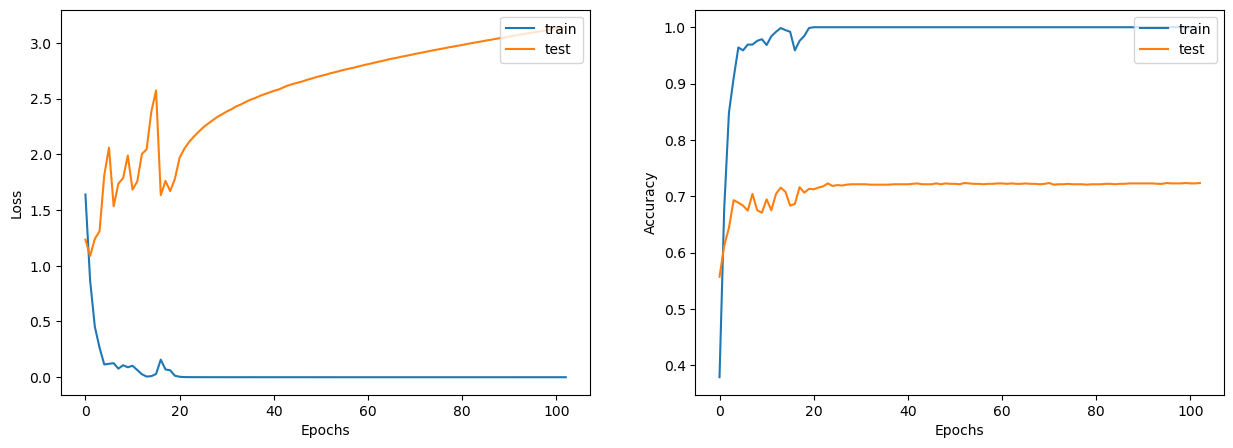

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "test"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history.history["accuracy"])
ax2.plot(history.history["val_accuracy"])
ax2.legend(["train", "test"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()